In [5]:
#%pip install pgmpy
#%pip install matplotlib
#%pip install scipy
#%pip install seaborn
#%pip install sklearn
#%pip install networkx

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

from sklearn.preprocessing import KBinsDiscretizer, normalize
from sklearn.metrics import accuracy_score
import warnings
from copy import copy
import networkx as nx

from pgmpy.estimators import HillClimbSearch, BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG

In [4]:
warnings.filterwarnings(action='ignore')

In [6]:
#this function is the numerator of the target distribution
def f(x):
    if x >= 0:
        return  np.exp(-(x/5)**4)
    else: 
        return  np.exp(-(1/10*x)**2+x)

#normal PDF
def g(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

In [9]:
data = pd.read_csv('owid-covid-data.csv')
data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231404,ZWE,Africa,Zimbabwe,2022-10-26,257893.0,0.0,0.0,5606.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231405,ZWE,Africa,Zimbabwe,2022-10-27,257893.0,0.0,0.0,5606.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231406,ZWE,Africa,Zimbabwe,2022-10-28,257893.0,0.0,0.0,5606.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231407,ZWE,Africa,Zimbabwe,2022-10-29,257893.0,0.0,0.0,5606.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN


In [10]:
columns = ['total_deaths_per_million',
            'positive_rate',
            'reproduction_rate',
            'new_people_vaccinated_smoothed_per_hundred',
            'gdp_per_capita',
            'population_density',
            'life_expectancy',
            'extreme_poverty',
            'hospital_beds_per_thousand',
            'total_cases_per_million'
           ]
df = data[columns].copy().dropna()
df.index = np.arange(0, len(df))
df.head()

,total_deaths_per_million,positive_rate,reproduction_rate,new_people_vaccinated_smoothed_per_hundred,gdp_per_capita,population_density,life_expectancy,extreme_poverty,hospital_beds_per_thousand,total_cases_per_million
0,438.726,0.1812,1.06,0.002,11803.431,104.871,78.57,1.1,2.89,22506.630
1,440.486,0.1788,1.07,0.002,11803.431,104.871,78.57,1.1,2.89,22737.428
2,441.893,0.1825,1.07,0.002,11803.431,104.871,78.57,1.1,2.89,22986.168
3,443.652,0.1807,1.07,0.002,11803.431,104.871,78.57,1.1,2.89,23218.373
4,445.059,0.1825,1.07,0.002,11803.431,104.871,78.57,1.1,2.89,23443.893


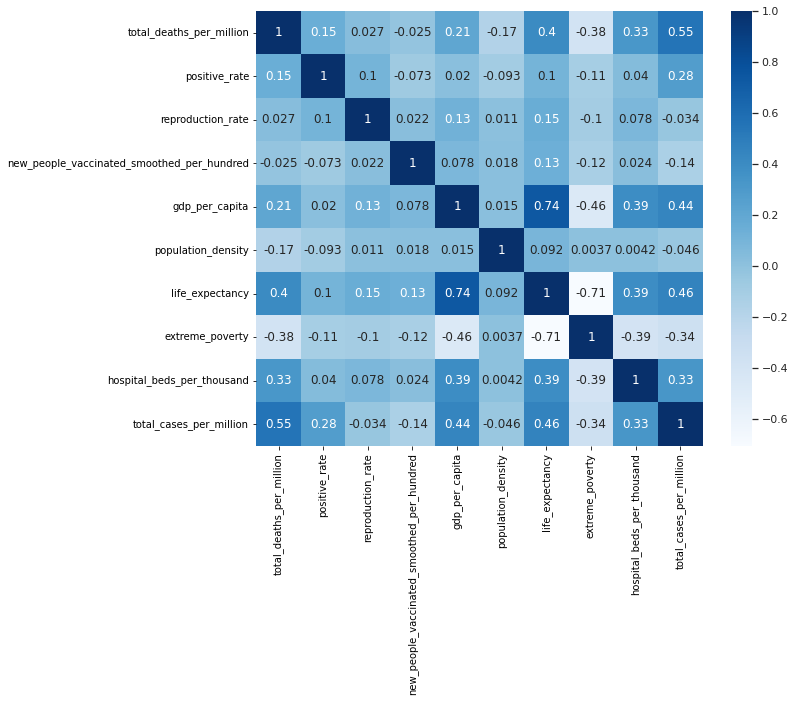

In [11]:
figure, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(df[columns].corr(), cmap='Blues', annot=True)

plt.show()

## 4

In [21]:
edges_list = [
    ('gdp_per_capita', 'total_deaths_per_million'),
    ('life_expectancy', 'total_deaths_per_million'),
    ('life_expectancy', 'gdp_per_capita'),
    ('extreme_poverty', 'total_deaths_per_million'),
    ('extreme_poverty', 'gdp_per_capita'),
    ('extreme_poverty', 'life_expectancy'),
    ('hospital_beds_per_thousand', 'total_deaths_per_million'),
    ('hospital_beds_per_thousand', 'gdp_per_capita'),
    ('hospital_beds_per_thousand', 'life_expectancy'),
    ('hospital_beds_per_thousand', 'extreme_poverty'),
    ('total_cases_per_million', 'total_deaths_per_million'),
    ('total_cases_per_million', 'positive_rate'),
    ('total_cases_per_million', 'gdp_per_capita'),
    ('total_cases_per_million', 'life_expectancy'),
    ('total_cases_per_million', 'extreme_poverty'),
    ('total_cases_per_million', 'hospital_beds_per_thousand')
]

our_model = BayesianModel(edges_list)

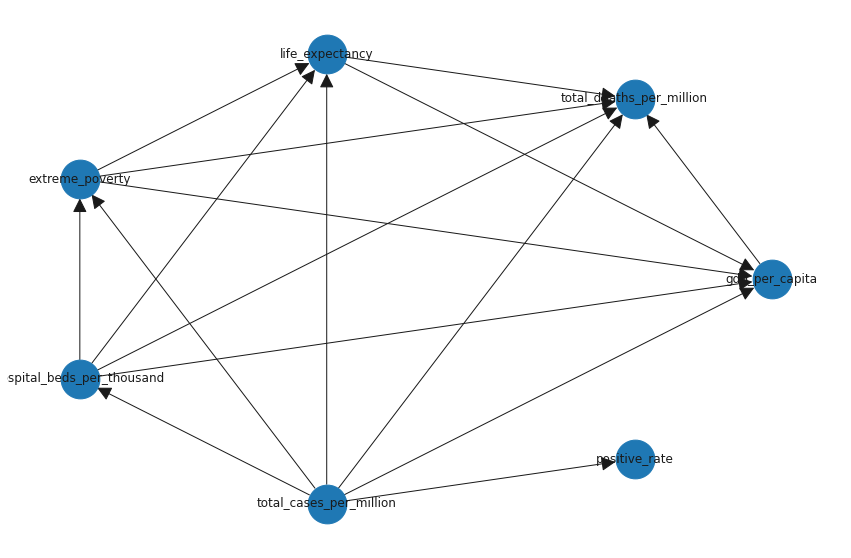

In [28]:
figure, ax = plt.subplots(1, 1, figsize=(15, 10))

graph = nx.DiGraph()
graph.add_edges_from(our_model.edges())

positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_size=1500, arrowsize=30)

plt.show()

In [33]:
subdata = df[[node for node in our_model.nodes()]]

In [35]:
transformed_data = subdata.copy()
bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_discrete = bins.fit_transform(subdata.values)

In [36]:
data_discrete = pd.DataFrame(data_discrete, columns=subdata.columns,index=subdata.index)
data_discrete

,gdp_per_capita,total_deaths_per_million,life_expectancy,extreme_poverty,hospital_beds_per_thousand,total_cases_per_million,positive_rate
0,0.0,0.0,3.0,0.0,1.0,0.0,2.0
1,0.0,0.0,3.0,0.0,1.0,0.0,2.0
2,0.0,0.0,3.0,0.0,1.0,0.0,2.0
3,0.0,0.0,3.0,0.0,1.0,0.0,2.0
4,0.0,0.0,3.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...
39607,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39608,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39609,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39610,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
from pgmpy.estimators import MaximumLikelihoodEstimator

In [37]:
our_model.fit(data_discrete, estimator=MaximumLikelihoodEstimator)

## 5

In [7]:
#transformation

transformed_data = copy(df)
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(df.values)
transformed_data[[
            'total_deaths_per_million',
            'positive_rate',
            'reproduction_rate',
            'new_people_vaccinated_smoothed_per_hundred',
            'gdp_per_capita',
            'population_density',
            'life_expectancy',
            'extreme_poverty',
            'hospital_beds_per_thousand',
            'total_cases_per_million'
            ]] = data_discrete

  0%|          | 52/1000000 [00:10<54:15:35,  5.12it/s] 


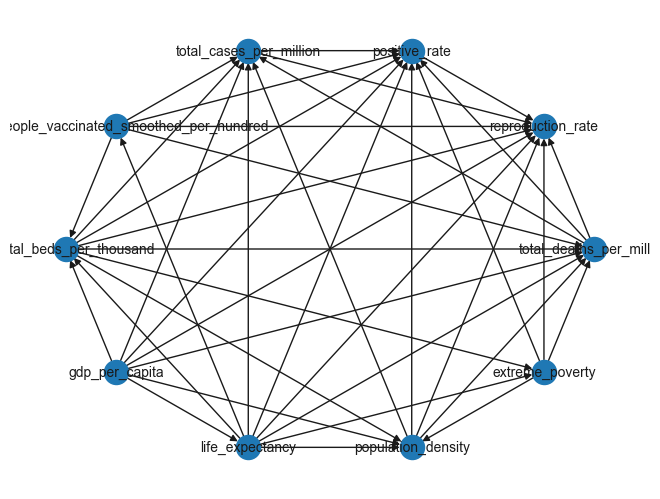

In [8]:
#k2 model

hc = HillClimbSearch(transformed_data)
model_K2 = hc.estimate(scoring_method=K2Score(transformed_data))

G_K2 = nx.DiGraph()
G_K2.add_edges_from(model_K2.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True, font_weight='light', font_size=10)

  0%|          | 21/1000000 [00:02<34:52:56,  7.96it/s]


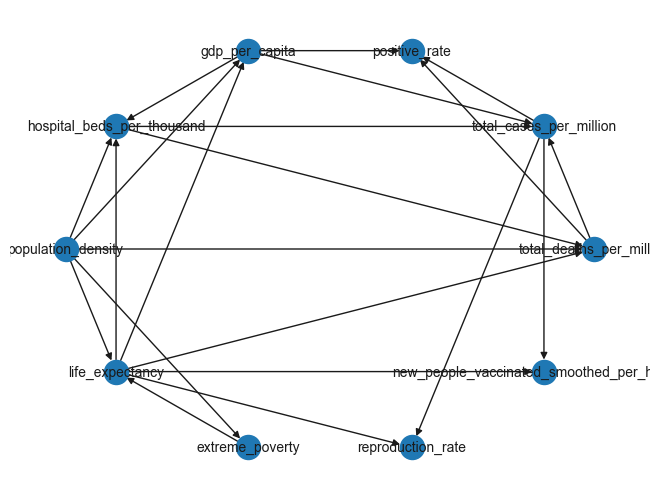

In [9]:
#bic model

hc_BicScore = HillClimbSearch(transformed_data)
best_model_BicScore = hc_BicScore.estimate(scoring_method=BicScore(transformed_data))

G_BicScore = nx.DiGraph()
G_BicScore.add_edges_from(best_model_BicScore.edges())
pos = nx.layout.circular_layout(G_BicScore)
nx.draw(G_BicScore, pos, with_labels=True,font_weight='light', font_size=10)

In [10]:
def sampling (bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n)
    return sample

In [11]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame):
    final_df = pd.DataFrame()
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    sns.barplot(x=parametr, y="Probability", hue="Data", data=final_df)
    plt.show()

In [ ]:
#k2 model sampling

sample_K2 = sampling(model_K2, transformed_data, len(transformed_data))

In [ ]:
#inverse tranform k2 model

sample_K2[[ 'total_deaths_per_million',
            'positive_rate',
            'reproduction_rate',
            'new_people_vaccinated_smoothed_per_hundred',
            'gdp_per_capita',
            'population_density',
            'life_expectancy',
            'extreme_poverty',
            'hospital_beds_per_thousand',
            'total_cases_per_million'
            ]] = est.inverse_transform(sample_K2[[ 
            'total_deaths_per_million',
            'positive_rate',
            'reproduction_rate',
            'new_people_vaccinated_smoothed_per_hundred',
            'gdp_per_capita',
            'population_density',
            'life_expectancy',
            'extreme_poverty',
            'hospital_beds_per_thousand',
            'total_cases_per_million']].values)

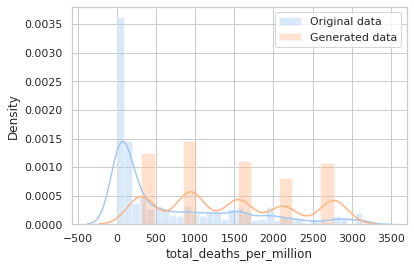

In [ ]:
sns.distplot(data['total_deaths_per_million'], label='Original data')
sns.distplot(sample_K2['total_deaths_per_million'], label='Generated data')
plt.legend()

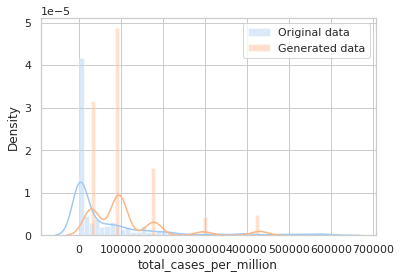

In [ ]:
sns.distplot(data['total_cases_per_million'], label='Original data')
sns.distplot(sample_K2['total_cases_per_million'], label='Generated data')
plt.legend()

In [13]:
#sample bic model

sample_Bic = sampling(best_model_BicScore, transformed_data, len(transformed_data))

Generating for node: reproduction_rate: 100%|██████████| 10/10 [00:00<00:00, 24.93it/s]                        


In [14]:
#inverse transform bic model

sample_Bic[[ 'total_deaths_per_million',
            'positive_rate',
            'reproduction_rate',
            'new_people_vaccinated_smoothed_per_hundred',
            'gdp_per_capita',
            'population_density',
            'life_expectancy',
            'extreme_poverty',
            'hospital_beds_per_thousand',
            'total_cases_per_million'
            ]] = est.inverse_transform(sample_Bic[[ 
            'total_deaths_per_million',
            'positive_rate',
            'reproduction_rate',
            'new_people_vaccinated_smoothed_per_hundred',
            'gdp_per_capita',
            'population_density',
            'life_expectancy',
            'extreme_poverty',
            'hospital_beds_per_thousand',
            'total_cases_per_million']].values)

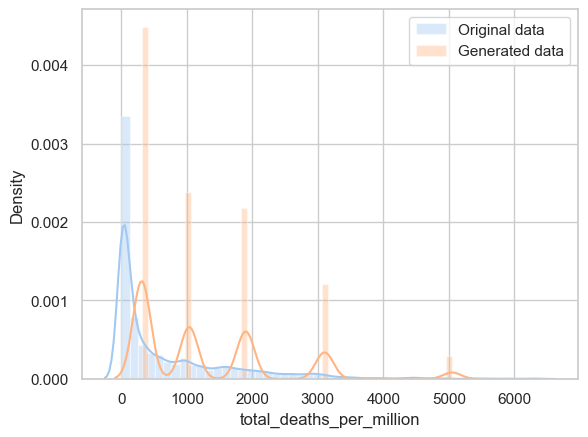

In [15]:
sns.distplot(data['total_deaths_per_million'], label='Original data')
sns.distplot(sample_Bic['total_deaths_per_million'], label='Generated data')
plt.legend()

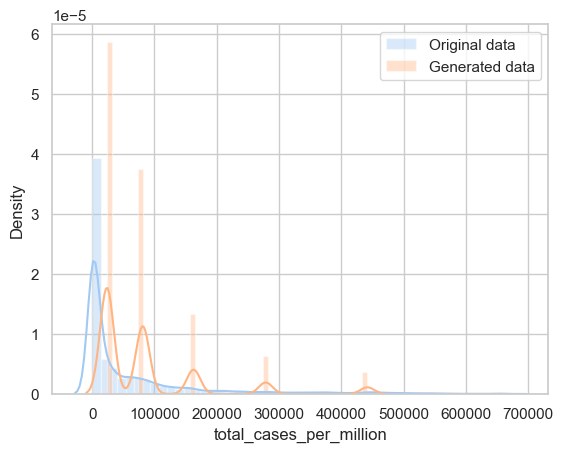

In [16]:
sns.distplot(data['total_cases_per_million'], label='Original data')
sns.distplot(sample_Bic['total_cases_per_million'], label='Generated data')
plt.legend()

In [20]:
def accuracy_params_restoration(bn: BayesianModel, data: pd.DataFrame):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param]
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result

In [ ]:
# accuracy estimation for bic model (stops running)

##accuracy_BIC = accuracy_params_restoration(BayesianModel(best_model_BicScore.edges()), transformed_data)